#### IMPORTS

In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression, \
                             make_blobs, make_circles, make_moons
from sklearn.base import BaseEstimator
# from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
from __future__ import annotations

#### REGRESSION AND CLASSIFICATION DATA GENERATION

In [4]:
X_reg, y_reg = make_regression(
    n_samples=100,                                  			
    n_features=5,                 			
    n_informative=3,                          			
    n_targets=1,                            			
    random_state=1
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
                                                    X_reg, y_reg, test_size=0.3)


X_clas, y_clas = make_classification(
    n_samples=100,  
    n_features=5, 
    n_informative=3, 
    n_classes=2, 
    random_state=1
)

X_clas_train, X_clas_test, y_clas_train, y_clas_test = train_test_split(
                                                    X_clas, y_clas, test_size=0.3)

# Cross Validation

In [5]:
class CrossValidation():
    
    def __init__(self, model, model_type: str, cv: int=5, 
                 return_train_score: bool=False, **model_params) -> None:
    
        self.model = model
        self.cv = cv
        self.scores = []
        self.return_train_score = return_train_score
        self.model_params = model_params
        
        if model_type not in {"regression", "classification"}:
            raise Exception("model_type must be in [\"regression\", \"classification\"]")
        
        self.model_type = model_type
        if self.model_type == "regression":
            self.scoring = metrics.mean_squared_error
        else:
            self.scoring = metrics.f1_score
            
    def _split_by_index(self, x: np.ndarray, start: int, stop: int) -> tuple:
        test = x[start : stop]
        train = np.delete(x, range(start, stop), axis=0)
        return train, test
        
    def validate(self, X: np.ndarray, y: np.ndarray) -> float:
        n_samples = y.size
        fold_size = n_samples // self.cv
        start, stop = 0, fold_size
        
        for _ in range(self.cv):
            X_train, X_test = self._split_by_index(X, start, stop)
            y_train, y_test = self._split_by_index(y, start, stop)
            
            model = self.model(**self.model_params)
                
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            try:
                score = self.scoring(y_test, y_pred)
                self.scores.append(score)
            except:
                # print("Extremal value!")
                # print(y_pred)
                continue
            
            start += fold_size
            stop += fold_size if stop < n_samples else n_samples
            
        if self.return_train_score:
            return self.scores
        else:
            return np.mean(self.scores)
                

# Grid Search with Cross Validation

In [6]:
class GridSearchCV():
    
    def __init__(self, model, param_grid: dict, model_type: str, cv: int=5) -> None:
        self.model = model
        self.param_grid = param_grid
        
        if model_type not in {"regression", "classification"}:
            raise Exception("model_type must be in [\"regression\", \"classification\"]")
        
        self.model_type = model_type
        self.cv = cv
            
    def fit(self, X: np.ndarray, y: np.ndarray) -> dict:
        
        self.best_params = None
        
        if self.model_type == "regression":
            self.best_score = np.inf
        else:
            self.best_score = 0
            
        params_combinations = itertools.product(*self.param_grid.values())
        
        for params_combination in params_combinations:
            params = dict(zip(self.param_grid.keys(), params_combination))
            CV = CrossValidation(self.model, model_type=self.model_type, cv=self.cv, **params)
            score = CV.validate(X, y)
            
            if (self.model_type == "regression") & (score < self.best_score):
                self.best_score, self.best_params = score, params
            
            if (self.model_type == "classification") & (score > self.best_score):
                self.best_score, self.best_params = score, params
        
        if self.best_params is None:
            self.best_params = params
        
        return self.best_params

# K-Neared Neigbors:

#### BASE KNN ALGORITHM 

In [7]:
class BasicKNN(BaseEstimator):

	def __init__(self, n_neighbors: int) -> None:
		raise NotImplementedError("Метод требует переопределения в классе наследования")
		
	def euclidian_dist(self, x: np.ndarray, y: np.ndarray) -> float:
		return np.linalg.norm(x - y)
	
	def fit(self, X_train, y_train) -> BasicKNN:
		self.X_train = X_train
		self.y_train = y_train
		return self
		
	def _get_indexes(self, dists: list) -> list:
		threshold = sorted(dists)[self.n_neighbors]
		indexes = [dists.index(i) for i in dists if i < threshold]
		return indexes

	def _pred_classiffication(self, neighbors_y: np.ndarray) -> int:
		y_pred_sample = np.argmax(np.bincount(neighbors_y))
		return y_pred_sample
        
		
	def predict(self, X_test) -> np.ndarray:
		y_pred = []

		for sample in X_test:
			dists = [self.euclidian_dist(sample, x) for x in self.X_train]
			neighbors_inds = self._get_indexes(dists)
			neighbors_y = self.y_train[neighbors_inds]

			y_pred_sample = self.pred_sample(neighbors_y)
			y_pred.append(y_pred_sample)
		
		return np.array(y_pred)

# 1. KNN for Regression

In [8]:
class KNNRegression(BasicKNN):
    
    def __init__(self, n_neighbors: int) -> None:
        self.n_neighbors = n_neighbors
        self.pred_sample = np.mean

In [9]:
# HYPER-PARAMS SELECTION

params_grid = {
    'n_neighbors': [2, 3, 5, 7, 10, 20, 30, 50],
}

GS = GridSearchCV(KNNRegression, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = KNNRegression(**best_params)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)

552.5477910905886 {'n_neighbors': 2}


# 2. KNN for Classification

In [10]:
class KNNClassification(BasicKNN):
    
    def __init__(self, n_neighbors: int) -> None:
        self.n_neighbors = n_neighbors
        self.pred_sample = self._pred_classiffication

In [11]:
# HYPER-PARAMS SELECTION

params_grid = {
    'n_neighbors': [2, 3, 5, 7, 10, 20, 30, 50],
}

GS = GridSearchCV(KNNClassification, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = KNNClassification(**best_params)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)

0.8571428571428571 {'n_neighbors': 2}


# Linear Models

# Basic Regression with Gradient Descendal Algorithm

In [12]:
class BasicRegression(BaseEstimator):
    
    def __init__(self, max_depth: int=None, criterion: str="entropy") -> None:
        raise NotImplementedError("Метод требует переопределения в классе наследования")

    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        bias = np.ones((X.shape[0], 1))
        X_with_bias = np.concatenate([X, bias], axis=1)
        return X_with_bias
        

    def fit(self, X_train: np.array, y_train: np.array) -> BasicRegression:
        self.loss_history = []
        X_train = self._add_bias(X_train)
        self.n_samples, self.n_features = X_train.shape
        self.w = self.w0 if self.w0 is not None else np.ones(self.n_features)
        
        for _ in range(int(self.max_iter)):
            if self.batch_size is not None:             
                inds = np.random.randint(0, self.n_samples, self.batch_size)
                X, y = X_train[inds], y_train[inds]
            else:
                X, y = X_train, y_train
                   
            grad_step = self.eta * self.calc_gradient(X, y)
            
            if (np.linalg.norm(grad_step) < self.tolerance) | \
               (np.any(np.isnan(grad_step) | np.isinf(grad_step))):
                break
            
            self.w -= grad_step
            self.loss_history.append(self.calc_loss(X_train, y_train))
            
        return self


    def predict_proba(self, X_test: np.array) -> np.array:
        if self.w is None:
            raise Exception('Not trained yet')

        proba_1 = np.expand_dims(self._sigma(X_test @ self.w), axis=1)
        proba_0 = 1 - proba_1
        return np.concatenate([proba_0, proba_1], axis=1)


    def predict(self, X_test: np.array) -> np.array:
        X_test = self._add_bias(X_test)
        if self.w is None:
            raise Exception('Not trained yet')
        
        if self.calc_gradient == self.calc_linear_gradient:
            y_pred = X_test @ self.w
        else:
            
            y_pred = np.round(self.predict_proba(X_test)[:, 1], 1).astype(int)
        return y_pred


    def calc_linear_gradient(self, X: np.array, y: np.array) -> np.array:
        grad = (X.T @ (X @ self.w - y)**2) / y.size
        return grad


    def calc_logistic_gradient(self, X: np.array, y: np.array) -> np.array:
        grad = (X.T @ (self._sigma(X @ self.w) - y)) / y.size
        return grad


    def _sigma(self, z: np.array) -> np.array:
        return 1 / (1 + np.exp(-z))
    
    
    def calc_linear_loss(self, X: np.array, y: np.array) -> float:
        y_pred = X @ self.w
        loss = np.mean((y_pred - y)**2)
        return loss


    def calc_logistic_loss(self, X: np.array, y: np.array) -> float:
        y_pred = self._sigma(X @ self.w)
        loss = -np.mean(y*np.log(y_pred) + 
                   (1-y)*np.log(1 - y_pred)) / len(y)
        return loss
      
    def show_loss(self) -> None:
        loss = self.loss_history
        iters = range(len(loss))
        plt.plot(iters, loss)
        plt.xlabel("Iteration")
        plt.ylabel("Loss value")
        plt.title("Loss function")
        plt.grid(True)
        
        plt.show()
        print(f"Final loss = {round(loss[-1], 4)}")

# 1. Linear Regression

In [13]:
class LinearRegression(BasicRegression):
    
    def __init__(self, tolerance: float = 1e-6, max_iter: int = 1e3, 
                 eta: float = 1e-2, w0: np.array = None) -> None:
        
        self.calc_gradient = self.calc_linear_gradient
        self.calc_loss = self.calc_linear_loss

        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None
        self.batch_size = None

2208.223138374894 {'eta': 1e-07, 'max_iter': 100.0}


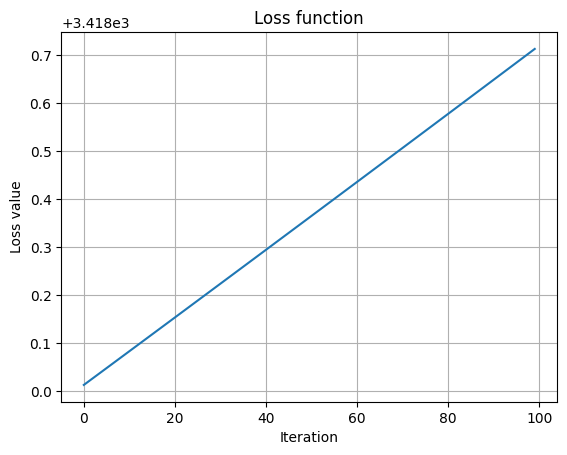

Final loss = 3418.7125


In [14]:
# HYPER-PARAMS SELECTION

params_grid = {
    'eta': [1e-2, 1e-3, 1-4, 1e-5, 1e-6, 1e-7],
    'max_iter': [1e2, 1e3, 1e4]
}

GS = GridSearchCV(LinearRegression, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = LinearRegression(**best_params)
# model = LinearRegression(eta=1e-5)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)
model.show_loss()

# 2. Stohastic Gradient Descendal (Regression Mode)

In [15]:
class SGDRegression(LinearRegression):
    
    def __init__(self, tolerance: float = 1e-6, max_iter: int = 1e3, 
                 eta: float = 1e-2, batch_size: int=10, w0: np.array = None) -> None:
        
        self.calc_gradient = self.calc_linear_gradient
        self.calc_loss = self.calc_linear_loss

        self.batch_size = batch_size
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

2207.4633125772334 {'eta': 1e-07, 'max_iter': 1000.0, 'batch_size': 1}


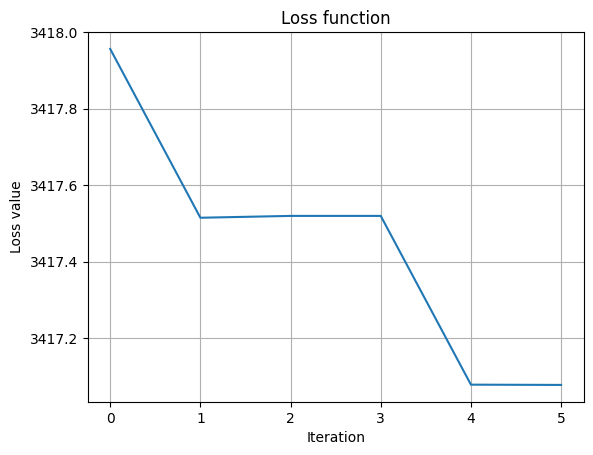

Final loss = 3417.0775


In [16]:
# HYPER-PARAMS SELECTION

params_grid = {
    'eta': [1e-2, 1e-3, 1-4, 1e-5, 1e-6, 1e-7],
    'max_iter': [1e2, 1e3, 1e4],
    'batch_size': [1, 5, 10, 20]
}

GS = GridSearchCV(SGDRegression, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = SGDRegression(**best_params)
# model = SGDRegression(eta=1e-5)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)
model.show_loss()

# 3. Logistic Regression

In [17]:
class LogisticRegression(BasicRegression):
    
    def __init__(self, tolerance: float = 1e-6, max_iter: int = 1e3, 
                 eta: float = 1e-2, w0: np.array = None) -> None:
        
        self.calc_gradient = self.calc_logistic_gradient
        self.calc_loss = self.calc_logistic_loss

        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None
        self.batch_size = None

0.6428571428571429 {'eta': 0.1, 'max_iter': 1000.0}


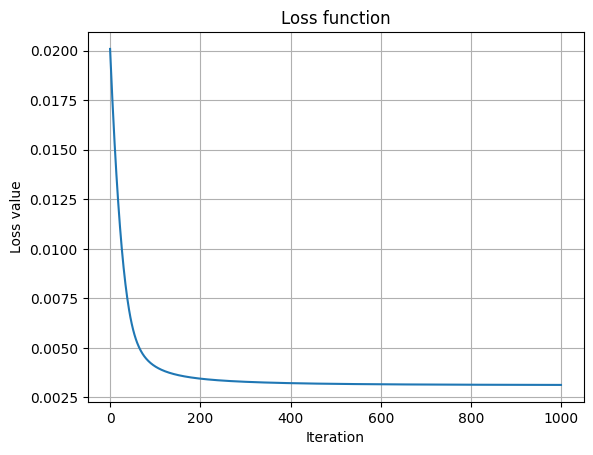

Final loss = 0.0031


In [18]:
# HYPER-PARAMS SELECTION

params_grid = {
    'eta': [1e-1, 1e-2, 1e-3, 1-4],
    'max_iter': [1e2, 1e3],
}

GS = GridSearchCV(LogisticRegression, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = LogisticRegression(**best_params)
# model = LogisticRegression(eta=1e-1)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)
model.show_loss()

# 4. Stohastic Gradient Descendal (Classification Mode)

In [19]:
class SGDClassification(LogisticRegression):
    
    def __init__(self, tolerance: float = 1e-6, max_iter: int = 1e3, 
                 eta: float = 1e-2, batch_size: int=10, w0: np.array = None) -> None:
        
        self.calc_gradient = self.calc_logistic_gradient
        self.calc_loss = self.calc_logistic_loss

        self.batch_size = batch_size
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

0.3333333333333333 {'eta': 0.01, 'max_iter': 10000.0, 'batch_size': 1}


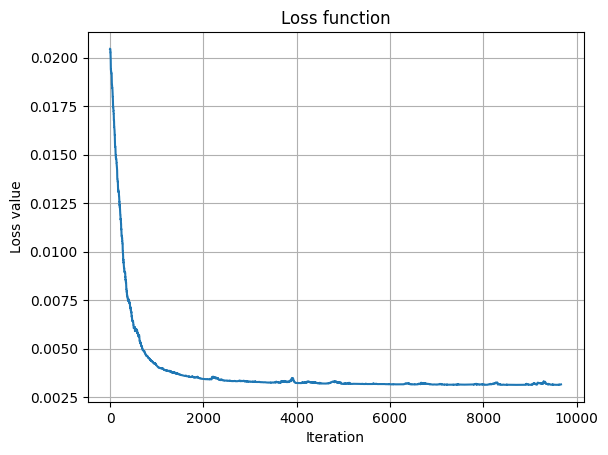

Final loss = 0.0032


In [20]:
# HYPER-PARAMS SELECTION

params_grid = {
    'eta': [1e-2, 1e-3, 1-4, 1e-5, 1e-6, 1e-7],
    'max_iter': [1e2, 1e3, 1e4],
    'batch_size': [1, 5, 10, 20]
}

GS = GridSearchCV(SGDClassification, params_grid, model_type='regression')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = SGDClassification(**best_params)
# model = SGDClassification(eta=1e-2)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.mean_squared_error(y_clas_pred, y_clas_test)
print(score, best_params)
model.show_loss()

In [ ]:
class SVM(BaseEstimator):
    
    def __init__(self, C = 1) -> None:
        self.C = C
        self.w = 0
        self.b = 0
        
    def hingeloss(self, w, b, X, y):
        reg = w**2 / 2
        
        w @ X 
        raise NotImplementedError

# Decision Trees:

# Basic Tree Algorithm

In [21]:
class BasicTree(BaseEstimator):
    
    def __init__(self, max_depth: int=None, criterion: str="entropy") -> None:
        raise NotImplementedError("Метод требует переопределения в классе наследования")
    
    
    def _entropy(self, y: np.ndarray) -> float:
        _, counts = np.unique(y, return_counts=True)
        probs = counts / y.size
        return -np.sum(probs * np.log2(probs))
    
        
    def _gini_index(self, y: np.ndarray) -> float:
        _, counts = np.unique(y, return_counts=True)
        probs = counts / y.size
        
        if not len(probs):
            return 0
        return 1 - np.sum(probs**2)
    
    
    def _varience(self, y: np.ndarray) -> float:
        return np.mean(((y - np.mean(y))**2))
    
    
    def find_best_split(self, X: np.ndarray, y: np.ndarray) -> tuple:
            
        best_feature, best_threshold = None, None
        best_gain = 0 if self.model_type == "classification" else np.inf
        
        for feature in range(X.shape[1]):
            thresholds = sorted(np.unique(X[:, feature]))
            
            for threshold in thresholds:
                left_inds = X[:, feature] <= threshold
                right_inds = X[:, feature] > threshold
                
                if sum(left_inds) == 0 or sum(right_inds) == 0:
                    continue
                
                left_y, right_y = y[left_inds], y[right_inds]
                
                if self.model_type == "classification":
                    gain = self.criterion(y) - (len(left_y) / len(y)) * self.criterion(left_y) - \
                                          (len(right_y) / len(y)) * self.criterion(right_y)
                    if gain > best_gain:
                        best_feature, best_threshold, best_gain = feature, threshold, gain
                        
                else:
                    gain = self.criterion(left_y) + self.criterion(right_y)
                    if gain < best_gain:
                        best_feature, best_threshold, best_gain = feature, threshold, gain
                        
        return best_feature, best_threshold, best_gain
    
    
    def _create_leaf_node(self, y: np.ndarray, y_pred: np.ndarray=None) -> dict:
        raise NotImplementedError("Метод требует переопределения в классе наследования")
    
    
    def _build_tree(self, X: np.ndarray, y: np.ndarray, 
                    depth: int, y_pred: np.ndarray=None) -> dict:
        if depth >= self.max_depth:
            if y_pred is not None:
                return self._create_leaf_node(y, y_pred)
            return self._create_leaf_node(y)
        
        best_feature, best_threshold, _ = self.find_best_split(X, y)
        if (best_feature is None) | (best_threshold is None):
            if y_pred is not None:
                return self._create_leaf_node(y, y_pred)
            return self._create_leaf_node(y)
        
        left_inds = X[:, best_feature] <= best_threshold
        right_inds = X[:, best_feature] > best_threshold
    
        if y_pred is not None:
            left_tree = self._build_tree(X[left_inds], y[left_inds], depth+1, y_pred[left_inds])
            right_tree = self._build_tree(X[right_inds], y[right_inds], depth+1, y_pred[right_inds])
        else:
            left_tree = self._build_tree(X[left_inds], y[left_inds], depth+1)
            right_tree = self._build_tree(X[right_inds], y[right_inds], depth+1)

        node = {'feature': best_feature, 'threshold': best_threshold, 
                'left': left_tree, 'right': right_tree}
        
        return node
    
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray, y_pred: np.ndarray=None) -> BasicTree:
        if y_pred is not None:
            self.tree = self._build_tree(X_train, y_train, depth=0, y_pred=y_pred)
        else:
            self.tree = self._build_tree(X_train, y_train, depth=0)
        return self
          
            
    def _traverse_tree(self, x, node: dict) -> float:
        if 'value' in node:
            return node['value']
                    
        if x[node['feature']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])
        
            
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.array([self._traverse_tree(x, self.tree) for x in X_test])

# 1. Regression Tree

In [22]:
class RegressionTree(BasicTree):
    
    def __init__(self, max_depth: int=None, criterion: str="mse") -> None:
        self.max_depth = max_depth
        self.criterion = self._varience
        self.model_type = "regression"
        self.tree = None
        
    def _create_leaf_node(self, y: np.ndarray, y_pred: np.ndarray=None) -> dict:
        return {'value': np.mean(y)}

In [23]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 2, 3, 5, 10, 20]
}

GS = GridSearchCV(RegressionTree, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = RegressionTree(**best_params)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)

981.0056974159776 {'max_depth': 3}


# 2. Classification Tree

In [24]:
class ClassificationTree(BasicTree):
    
    def __init__(self, max_depth: int=None, criterion: str="entropy") -> None:
        self.max_depth = max_depth
        if criterion == "entropy":
            self.criterion = self._entropy
        elif criterion == "gini":
            self.criterion = self._gini_index
        else:
            raise Exception("Criterion must be in [\"entropy\", \"gini\"]")
        self.model_type = "classification"
        self.tree = None
        
    def _create_leaf_node(self, y: np.ndarray, y_pred: np.ndarray=None) -> dict:
        if y_pred is not None:
            return {'value': np.sum(y) / np.sum(y_pred * (1 - y_pred))}
        else:
            unique_classes, counts = np.unique(y, return_counts=True)
            most_common_class = unique_classes[np.argmax(counts)]
            return {'value': most_common_class}

In [25]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 2, 3, 5, 10, 20],
    'criterion': ['entropy', 'gini']
}

GS = GridSearchCV(ClassificationTree, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = ClassificationTree(**best_params)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)

0.9473684210526316 {'max_depth': 5, 'criterion': 'entropy'}


# Base Bagging Algorithm

In [26]:
class Bagging():
    
    def __init__(self) -> None:
        raise NotImplementedError("Метод требует переопределения в классе наследования")
        
        
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> Bagging:
        n_samples = y_train.size
        if self.batch_size is None:
            self.batch_size = n_samples
        
        for _ in range(self.n_estimators):
            estimator = self.model(max_depth=self.max_depth, 
                                   criterion=self.criterion) 
             
            inds = np.random.randint(0, n_samples, self.batch_size)
            X_sampled = X_train[inds]
            y_sampled = y_train[inds]
            
            estimator.fit(X_sampled, y_sampled)
            self.estimators.append(estimator)
            
        return self
            
            
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        predictions = np.zeros(len(X_test))
        
        for estimator in self.estimators:
            predictions += estimator.predict(X_test)
        
        predictions /= self.n_estimators
        
        if self.model == ClassificationTree:
            return np.round(predictions)  
        return predictions

# 3. Bagging Regression Tree

In [27]:
class BaggingRegressionTree(Bagging):
    
    def __init__(self, n_estimators: int=10, max_depth: int=None, 
                 criterion: str="mse") -> None:
        self.model = RegressionTree
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.batch_size = None
        self.estimators = []

In [28]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20]
}

GS = GridSearchCV(BaggingRegressionTree, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = BaggingRegressionTree(**best_params)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)

527.5797356797746 {'max_depth': 10, 'n_estimators': 10}


# 4. Random Forest Regression

In [29]:
class RandomForestRegression(BaggingRegressionTree):
    
    def __init__(self, n_estimators: int=10, batch_size: int=10, 
                 max_depth: int = None, criterion="mse") -> None:
        self.model = RegressionTree
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.batch_size = batch_size
        self.estimators = []

In [30]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20],
    'batch_size': [1, 5, 10, 20]
}

GS = GridSearchCV(RandomForestRegression, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = RandomForestRegression(**best_params)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)

599.7527861431565 {'max_depth': 5, 'n_estimators': 20, 'batch_size': 20}


# 5. Bagging Classification Tree

In [31]:
class BaggingClassificationTree(Bagging):
    
    def __init__(self, n_estimators: int=10, max_depth: int=None, 
                 criterion: str="entropy") -> None:
        self.model = ClassificationTree
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.batch_size = None   
        self.estimators = []

In [32]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20],
    'criterion': ['entropy', 'gini']
}

GS = GridSearchCV(BaggingClassificationTree, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = BaggingClassificationTree(**best_params)
# model = ClassificationTree(max_depth=)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)

0.8387096774193548 {'max_depth': 5, 'n_estimators': 5, 'criterion': 'gini'}


# 6. Random Forest Classification

In [33]:
class RandomForestClassification(BaggingClassificationTree):
    
    def __init__(self, n_estimators: int=10, batch_size: int=10, 
                 max_depth: int = None, criterion="entropy") -> None:
        self.model = ClassificationTree
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.batch_size = batch_size
        self.estimators = []

In [34]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20],
    'batch_size': [1, 5, 10, 20],
    'criterion': ['entropy', 'gini']
}

GS = GridSearchCV(RandomForestClassification, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = RandomForestClassification(**best_params)
# model = ClassificationTree(max_depth=)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)

0.8888888888888888 {'max_depth': 5, 'n_estimators': 5, 'batch_size': 20, 'criterion': 'gini'}


In [35]:
class GradientBoostingRegression:
    
    def __init__(self, n_estimators: int=100, learning_rate: float=0.1, 
                 max_depth: int=3) -> None:
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> GradientBoostingRegression:
        predictions = np.zeros(y_train.size)
        
        for _ in range(self.n_estimators):
            residuals = y_train - predictions
            
            tree = RegressionTree(max_depth=self.max_depth)
            tree.fit(X_train, residuals)
            tree_predictions = tree.predict(X_train)
            
            predictions += self.learning_rate * tree_predictions
            self.estimators.append(tree)
        
        return self
    
    def predict(self, X_test):
        predictions = np.zeros(X_test.shape[0])
        
        for tree in self.estimators:
            tree_predictions = tree.predict(X_test)
            predictions += self.learning_rate * tree_predictions
            
        return predictions

In [36]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20]
}

GS = GridSearchCV(GradientBoostingRegression, params_grid, model_type='regression')
GS.fit(X_reg_train, y_reg_train)
best_params = GS.best_params

# FITTING MODEL

model = GradientBoostingRegression(**best_params)
			 
model.fit(X_reg_train, y_reg_train)
y_reg_pred = model.predict(X_reg_test)
score = metrics.mean_squared_error(y_reg_pred, y_reg_test)
print(score, best_params)

545.7983824304506 {'max_depth': 5, 'n_estimators': 20}


In [37]:
class GradientBoostingClassification:
    
    def __init__(self, n_estimators: int=100, learning_rate: float=0.1, 
                 max_depth: int=3) -> None:
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> GradientBoostingRegression:
        predictions = np.full_like(y_train, self._sigmoid(
                      np.log(np.count_nonzero(y_train == 1) / np.count_nonzero(y_train == 0))),
                                                                             dtype=np.float64)
        
        for _ in range(self.n_estimators):
            residuals = y_train - predictions
            
            tree = ClassificationTree(max_depth=self.max_depth)
            tree.fit(X_train, residuals, predictions)
            tree_predictions = tree.predict(X_train)
            
            predictions += self.learning_rate * tree_predictions
            self.estimators.append(tree)
        
        return self
    
    def predict(self, X_test):
        predictions = np.full(X_test.shape[0], 0.5)
        
        for tree in self.estimators:
            tree_predictions = tree.predict(X_test)
            predictions += self.learning_rate * tree_predictions
            
        predictions = np.round(predictions, 1).astype(int)
            
        return predictions
                
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [38]:
# HYPER-PARAMS SELECTION

params_grid = {
    'max_depth': [1, 3, 5, 10, 20],
    'n_estimators': [3, 5, 10, 20],
}

GS = GridSearchCV(GradientBoostingClassification, params_grid, model_type='classification')
GS.fit(X_clas_train, y_clas_train)
best_params = GS.best_params

# FITTING MODEL

model = GradientBoostingClassification(**best_params)
# model = ClassificationTree(max_depth=)
			 
model.fit(X_clas_train, y_clas_train)
y_clas_pred = model.predict(X_clas_test)
score = metrics.f1_score(y_clas_pred, y_clas_test)
print(score, best_params)

0.9473684210526316 {'max_depth': 5, 'n_estimators': 3}


# CLUSTERING

In [224]:
class ClusterBasic(BaseEstimator):
    
    def __init__(self) -> None:
        raise NotImplementedError("Метод требует переопределения в классе наследования")
    
    def show_clusters(self, X: np.ndarray, show_centroids: bool=False) -> None:
        if self.labels is None:
            raise Exception('Not trained yet')        
        elif show_centroids:
            plt.scatter(self.centroids[:, 0], self.centroids[:, 1], color='red')
        
        plt.scatter(X[:, 0], X[:, 1], c=self.labels)
        plt.show()
        
    def l2(self, x1: np.ndarray, x2: np.ndarray, axis: int=0) -> float:
        return np.linalg.norm(x1 - x2, axis=axis)
    
    def predict(self, show: bool=False) -> np.ndarray:
        if self.labels is None:
            raise Exception('Not trained yet')
        elif show:
            self.show_clusters(self.X) 
        return self.labels

#### CLUSTERING DATA GENERATION

In [166]:
X, true_labels = make_blobs(
    n_samples=100,
    n_features=2, 
    centers=4, 
    cluster_std=0.8,
    
)

# 1. K-Means

In [218]:
class KMeans(ClusterBasic):
    
    def __init__(self, k: int=5, max_iter: int=100) -> None:
        self.k = k
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None
        
    def fit(self, X: np.ndarray) -> KMeans:
        self.centroids = X[np.random.randint(0, X.shape[0], self.k)] 
        
        for _ in range(self.max_iter):
            self.predict(X)
            
            # new_centroids = np.array([X[self.labels == i].mean(axis=0) for i in range(self.k)])
            
            new_centroids = []
            for i in range(self.k):
                centroid = X[self.labels == i].mean(axis=0)
                new_centroids.append(centroid)
            new_centroids = np.array(new_centroids)
            
            if np.all(new_centroids == self.centroids):
                break
            
            self.centroids = new_centroids
        return self
            
        
    def predict(self, X: np.ndarray, show: bool=False) -> np.ndarray:
        if self.centroids is None:
            raise Exception('Not trained yet')
        
        # labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - 
        #                     self.centroids, axis=-1), axis=-1)
        
        labels_list = []
        for x in X:
            x = np.expand_dims(x, axis=1)
            dists = self.l2(x, self.centroids.T, axis=0)
            label = np.argmin(dists)
            labels_list.append(label)
        
        self.labels = np.array(labels_list)
        
        if show:
            self.show_clusters(X)    
        return self.labels

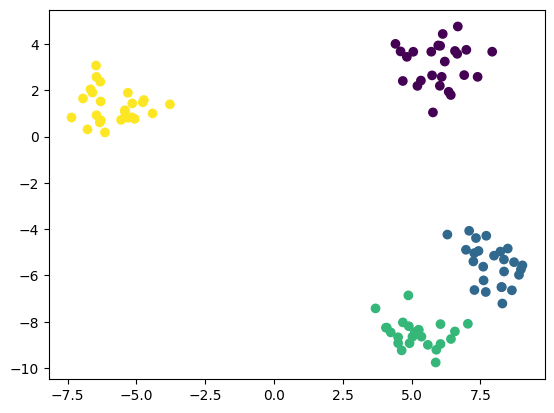

In [220]:
model = KMeans(4, 1000)
model.fit(X)
labels_pred = model.predict(X, show=True)

# 2. DBSCAN

In [222]:
class DBSCAN(ClusterBasic):
    
    def __init__(self, eps: float, min_samples: int) -> None:
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None
        
        
    def fit(self, X: np.ndarray) -> DBSCAN:
        self.X = X
        self.n_samples = len(X)
        self.labels = np.zeros(self.n_samples)
        
        cluster_label = 0
        
        for i in range(self.n_samples):
            if self.labels[i] != 0:
                continue
            
            neighbors = self._find_neighbors(i)
            
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1
            else:
                cluster_label += 1
                self._expand_cluster(i, cluster_label, neighbors)         
        return self
    
    
    def predict(self, show: bool=False) -> np.ndarray:
        if self.labels is None:
            raise Exception('Not trained yet')
        elif show:
            self.show_clusters(self.X) 
        return self.labels
    
    
    def _find_neighbors(self, point_index: int) -> list:
        neighbors = []
        
        for i in range(self.n_samples):
            if self.l2(self.X[i], self.X[point_index]) <= self.eps:
                neighbors.append(i)
                
        return neighbors
    
    
    def _expand_cluster(self, point_index, cluster_label, neighbors):
        self.labels[point_index] = cluster_label
        
        i = 0
        while i < len(neighbors) and i < 200:
            neighbor = neighbors[i]
            
            if self.labels[neighbor] == -1:
                self.labels[neighbor] = cluster_label
            elif self.labels[neighbor] == 0:
                self.labels[neighbor] = cluster_label
                new_neighbors = self._find_neighbors(neighbor)
                
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors

            i += 1

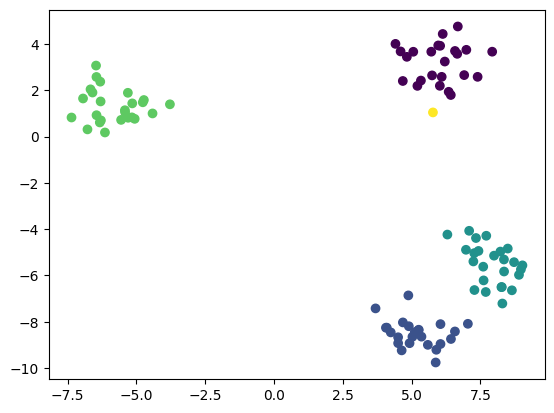

In [216]:
model = DBSCAN(eps=1.5, min_samples=3)
model.fit(X)
labels_pred = model.predict(show=True)

# 3. Agglomerative Clustering

In [234]:
class AgglomerativeClustering(ClusterBasic):
    
    def __init__(self, n_clusters: int, cluster_dist: str='min') -> None:
        self.n_clusters = n_clusters
        self.labels = None
        
        if cluster_dist not in {'min', 'max', 'mean', 'centroid'}:
            raise Exception("cluster_dist must be in ['min', 'max', 'mean', 'centroid']")
        self.cluster_dist = cluster_dist
        if cluster_dist == 'centroid':
            self._count_cluster_dist = self._centroid_dist
        else:
            self._count_cluster_dist = self._points_dist
            
        
    def fit(self, X: np.ndarray) -> AgglomerativeClustering:
        self.X = X
        self.n_samples = X.shape[0]
        self.clusters = [[x] for x in X]
        
        while len(self.clusters) > self.n_clusters:
            x, y = self._get_nearest_min_clusters_inds()
            merged_cluster = self.clusters[x] + self.clusters[y]
            self.clusters.pop(x)
            self.clusters.pop(y-1)
            self.clusters.append(merged_cluster)
        
        self._assign_labels()
        
        
    def _assign_labels(self) -> None:
        self.labels = np.zeros(self.n_samples)
        
        for i in range(self.n_samples):
            for j in range(self.n_clusters):
                if np.sum(np.all(self.X[i] == self.clusters[j], axis=1)) > 0:
                    self.labels[i] = j
                                
            
    def _get_nearest_min_clusters_inds(self) -> tuple:
        min_dist, neared_clusters_inds = np.inf, None
        n_clusters = len(self.clusters)
        
        for i in range(n_clusters-1):
            for j in range(i+1, n_clusters):
                dist = self._count_cluster_dist(i, j)
                if dist < min_dist:
                    min_dist, neared_clusters_inds = dist, (i, j)
        
        return neared_clusters_inds
    
                
    def _calc_centroid(self, cluster: list) -> np.ndarray:
        n_points = len(cluster)
        centroid = np.array(cluster).sum(axis=0) / n_points
        return centroid
    
    
    def _centroid_dist(self, x_ind: int, y_ind: int) -> float:
        centroid_x = self._calc_centroid(self.clusters[x_ind])
        centroid_y = self._calc_centroid(self.clusters[y_ind])
        return self.l2(centroid_x, centroid_y)
    
    
    def _points_dist(self, x_ind: int, y_ind: int) -> float:
        dists = []
        for x_point in self.clusters[x_ind]:
            for y_point in self.clusters[y_ind]:
                dists.append(self.l2(x_point, y_point))
        if self.cluster_dist == 'mean':
            return np.mean(dists)
        elif self.cluster_dist == 'min':
            return min(dists)
        elif self.cluster_dist == 'max':
            return max(dists)

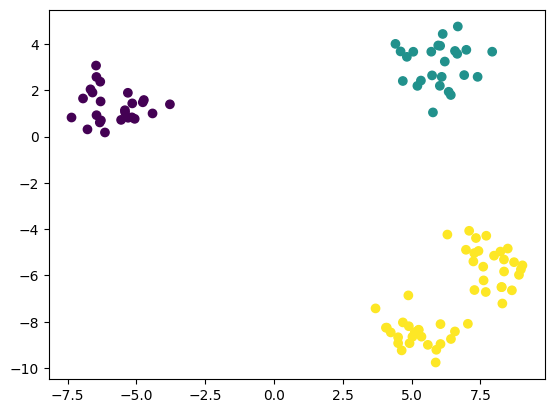

In [246]:
model = AgglomerativeClustering(n_clusters=3, cluster_dist='centroid')
model.fit(X)
labels_pred = model.predict(show=True)

# Dimensionality Reduction

# 1. PCA

In [43]:
class PCA(BaseEstimator):
    
    def __init__(self, n_components) -> None:
        self.n_components = n_components
        self.components = None
        self.mean = None
        
    def fit(self, X: np.ndarray) -> PCA:
        self.mean = X.mean(axis=0)
        X_centered = X - self.mean
                
        covariance_matrix = np.cov(X_centered.T)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        
        eigen_inds = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, eigen_inds]
        
        self.components = sorted_eigenvectors[:, :self.n_components]
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.components is None:
            raise Exception('Not trained yet')
        
        X_centered = X - self.mean
        transformed = X_centered @ self.components
        return transformed
    
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

In [44]:
X_decomp = np.random.randint(0, 100, (10, 5))

model = PCA(2)
X_transformed = model.fit_transform(X_decomp)
display(X_decomp, X_transformed)

array([[ 1, 66, 68, 35, 53],
       [31, 10, 18, 81, 99],
       [64,  6, 44, 17,  1],
       [ 4, 18, 41,  3,  8],
       [28, 29,  1, 78, 55],
       [43,  4, 14, 62, 87],
       [65, 79, 99, 26,  1],
       [90,  6, 31, 79,  5],
       [59, 87, 88, 12, 56],
       [98, 63, 70, 32, 64]])

array([[ 18.07077872, -40.37669321],
       [-73.28554022, -31.16955155],
       [ 13.05282179,  54.3352427 ],
       [ 10.17660718,  25.86360651],
       [-56.3021821 ,  -3.55292617],
       [-63.28389527, -14.01490254],
       [ 78.78237823,   7.43675576],
       [-19.88782838,  60.15948133],
       [ 60.35451509, -39.48185885],
       [ 32.32234497, -19.19915398]])